# Symbol Tutorial

Besides the tensor computation interface [NDArray](./ndarray.ipynb), another main object in MXNet is the `Symbol` provided by `mxnet.symbol`, or `mxnet.sym` for short. A symbol represents a multi-output symbolic expression. They are composited by operators, such as simple matrix operations (e.g. “+”), or a neural network layer (e.g. convolution layer). An operator can take several input variables, produce more than one output variables, and have internal state variables. A variable can be either free, which we can bind with value later, or an output of another symbol. 

## Symbol Composition 
### Basic Operators
The following example composites a simple expression `a+b`. We first create the placeholders `a` and `b` with names using `mx.sym.Variable`, and then construct the desired symbol by using the operator `+`. When the string name is not given during creating, MXNet will automatically generate a unique name for the symbol, which is the case for `c`. 

In [1]:
import mxnet as mx
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
assert a.name == "a", "Symbol name incorrect."
assert b.name == "b", "Symbol name incorrect."
(a, b, c)

(<Symbol a>, <Symbol b>, <Symbol _plus0>)

Most `NDArray` operators can be applied to `Symbol`, for example: 

In [2]:
# elemental wise times
d = a * b  
# matrix multiplication
e = mx.sym.dot(a, b)   
# reshape
f = mx.sym.Reshape(a, shape=(2,6))  
# broadcast
g = mx.sym.broadcast_to(f, shape=(3,2,6))  

### Basic Neural Networks

Besides the basic operators, `Symbol` has a rich set of neural network layers. The following codes construct a two layer fully connected neural work and then visualize the structure by given the input data shape. 

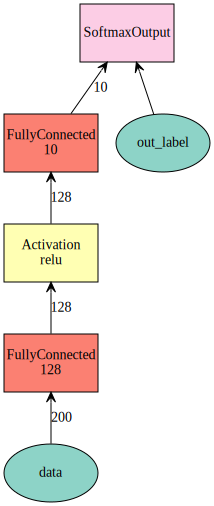

In [3]:
# Output may vary
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100,200)})

### Modulelized Construction for Deep Networks
For deep networks, such as the Google Inception, constructing layer by layer is painful given the large number of layers. For these networks, we often modularize the construction. Take the Google Inception as an example, we can first define a factory function to chain the convolution layer, batch normalization layer, and Relu activation layer together:

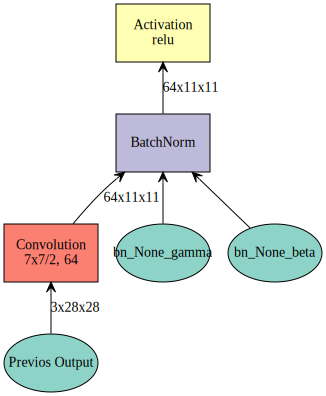

In [4]:
# Output may vary
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), name=None, suffix=''):
    conv = mx.symbol.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    bn = mx.symbol.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.symbol.Activation(data=bn, act_type='relu', name='relu_%s%s' %(name, suffix))
    return act
prev = mx.symbol.Variable(name="Previos Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
shape = {"Previos Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

Then we define a function that constructs an Inception module based on `ConvFactory`

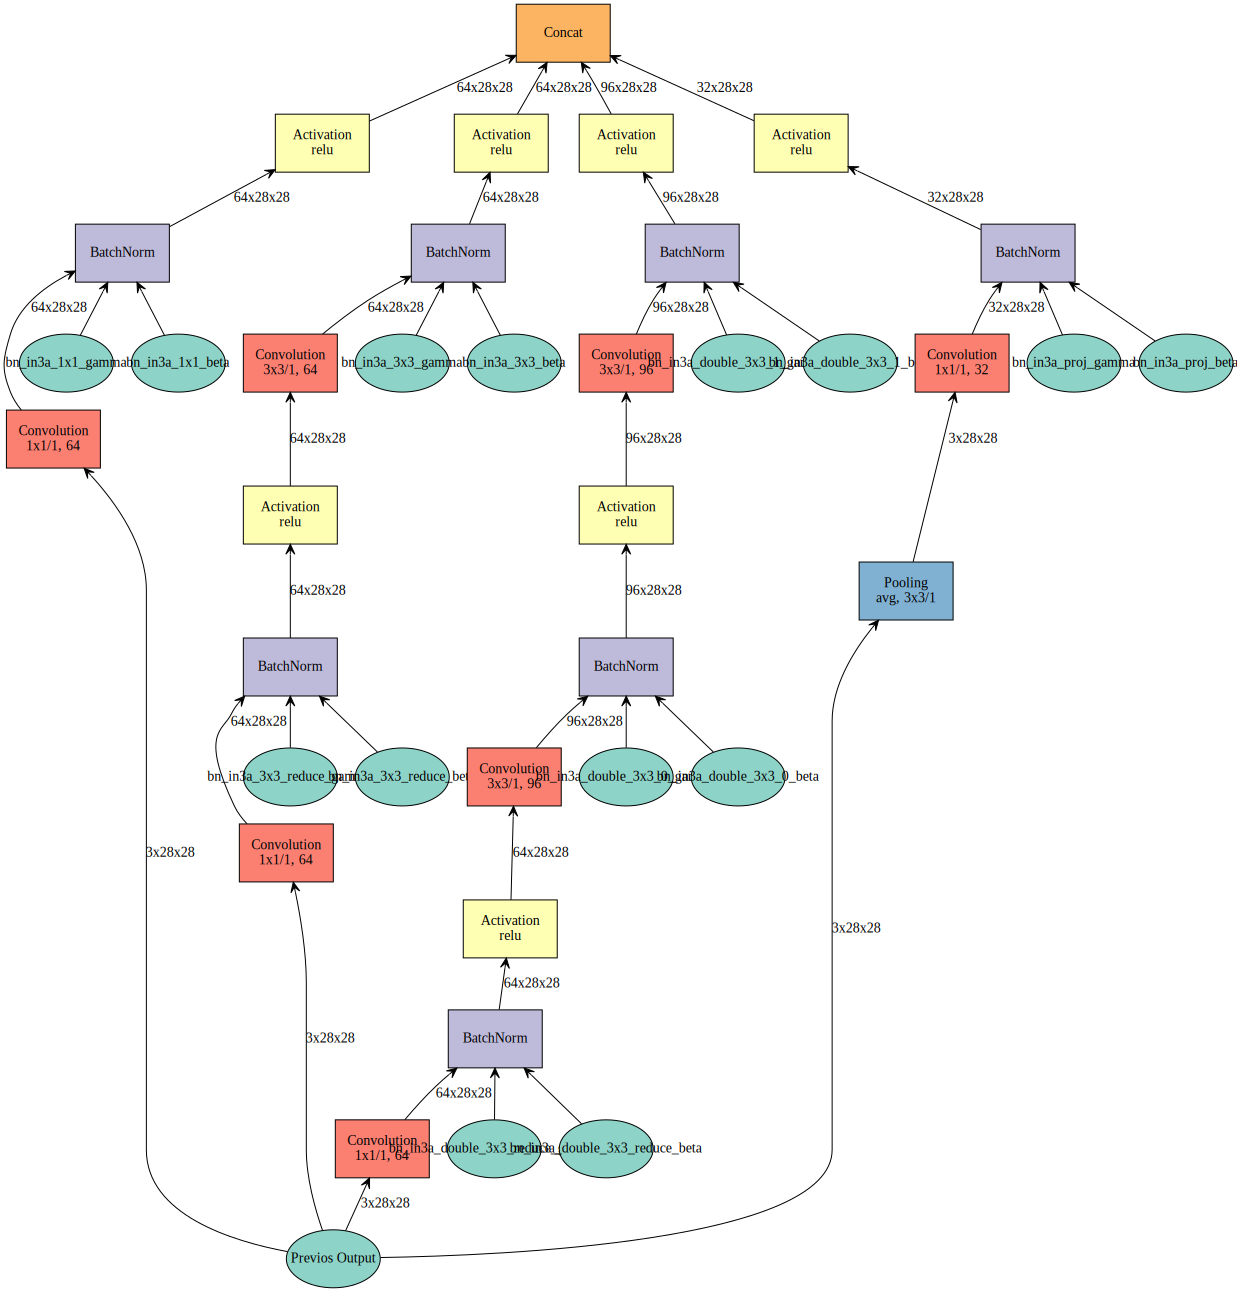

In [5]:
# Output may vary
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3, pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.symbol.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.symbol.Variable(name="Previos Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)

Finally we can obtain the whole network by chaining multiple inception modulas. A complete example is available at [mxnet/example/image-classification/symbol_inception-bn.py](https://github.com/dmlc/mxnet/blob/master/example/image-classification/symbol_inception-bn.py)

### Group Multiple Symbols

To construct neural networks with multiple loss layers, we can use `mxnet.sym.Group` to group multiple symbols together. The following example group two outputs:

In [6]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

## Relations to NDArray

As can be seen now, both Symbol and NDArray provide multi-dimensional array operations, such as `c=a+b` in MXNet. Sometimes users are confused which way to use. We briefly clarify the difference here, more detailed explanation are available [here](http://mxnet.readthedocs.io/en/latest/system/program_model.html). 

The `NDArray` provides an imperative programming alike interface, in which the computations are evaluated sentence by sentence. While `Symbol` is closer to declarative programming, in which we first declare the computation, and then evaluate with data. Examples in this category include regular expression and SQL.

The pros for `NDArray`:
- straightforward
- easy to work with other language features (for loop, if-else condition, ..) and libraries (numpy, ..)
- easy to step-by-step debug

The pros for `Symbol`:
- provides almost all functionalities of NDArray, such as +, \*, sin, and reshape 
- provides a large number of neural network related operators such as Convolution, Activation, and BatchNorm
- provides automatic differentiation 
- easy to construct and manipulate complex computations such as deep neural networks
- easy to save, load, and visualization
- easy for the backend to optimize the computation and memory usage

We will show on the [mixed programming tutorial](./mixed.ipynb) how these two interfaces can be used together to develop a complete training program. This tutorial will focus on the usage of Symbol. 

## Symbol Manipulation *

One important difference of `Symbol` comparing to `NDArray` is that, we first declare the computation, and then bind with data to run. 

In this section we introduce the functions to manipulate a symbol directly. But note that, most of them are wrapped nicely by the [`mx.module`](./module.ipynb). One can skip this section safely.  

### Shape Inference
For each symbol, we can query its inputs (or arguments) and outputs. We can also inference the output shape by given the input shape, which facilitates memory allocation. 

In [7]:
arg_name = c.list_arguments()  # get the names of the inputs
out_name = c.list_outputs()    # get the names of the outputs
arg_shape, out_shape, _ = c.infer_shape(a=(2,3), b=(2,3))  
{'input' : dict(zip(arg_name, arg_shape)), 
 'output' : dict(zip(out_name, out_shape))}

{'input': {'a': (2L, 3L), 'b': (2L, 3L)},
 'output': {'_plus0_output': (2L, 3L)}}

### Bind with Data and Evaluate
The symbol `c` we constructed declares what computation should be run. To evaluate it, we need to feed arguments, namely free variables, with data first. We can do it by using the `bind` method, which accepts device context and a `dict` mapping free variable names to `NDArray`s as arguments and returns an executor. The executor provides method `forward` for evaluation and attribute `outputs` to get all results. 

In [8]:
"""test_ndarray_element_value"""
import numpy as np

def test_val(nd_array, val):
    for num in np.nditer(nd_array):
        assert round(num, 7) == round(val, 7), "NDArray element value incorrect."

In [9]:
ex = c.bind(ctx=mx.cpu(), args={'a' : mx.nd.ones([2,3]), 
                                'b' : mx.nd.ones([2,3])})
ex.forward()
test_val(ex.outputs[0].asnumpy(), 2)
print 'number of outputs = %d\nthe first output = \n%s' % (
           len(ex.outputs), ex.outputs[0].asnumpy())

number of outputs = 1
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


We can evaluate the same symbol on GPU with different data

In [10]:
ex_gpu = c.bind(ctx=mx.gpu(), args={'a' : mx.nd.ones([3,4])*2,
                                    'b' : mx.nd.ones([3,4])*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

### Load and Save

Similar to NDArray, we can either serialize a `Symbol` object by using `pickle`, or use `save` and `load` directly. Different to the binary format chosen by `NDArray`, `Symbol` uses the more readable json format for serialization. The `tojson` method returns the json string.

In [11]:
print(c.tojson())
c.save('symbol-c.json')
c2 = mx.symbol.load('symbol-c.json')
c.tojson() == c2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "param": {}, 
      "name": "a", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "b", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "_Plus", 
      "param": {}, 
      "name": "_plus0", 
      "inputs": [[0, 0], [1, 0]], 
      "backward_source_id": -1
    }
  ], 
  "arg_nodes": [0, 1], 
  "heads": [[2, 0]]
}


True

### Auto Differentiation

Auto differentiation is one of the most important feature Symbol differs to NDArray. We can use the method `grad` to obtain the symbol for calculating the gradient. 

In [12]:
x = c.grad(wrt=('a'))
print x.list_arguments()
print x.list_outputs()

ex2 = x.bind(ctx=mx.cpu(), args={c.name+'_0_grad': mx.nd.ones([3,4])*5, 
                                 'a': mx.nd.ones([3,4])*2,
                                 'b' : mx.nd.ones([3,4])*3})
ex2.forward()
test_val(ex2.outputs[0].asnumpy(), 5)
print ex2.outputs[0].asnumpy()

['_plus0_0_grad', 'a', 'b']
['_plus0_backward_lhs']
[[ 5.  5.  5.  5.]
 [ 5.  5.  5.  5.]
 [ 5.  5.  5.  5.]]


## Customized Symbol *

Most operators such as `mx.sym.Convolution` and `mx.sym.Reshape` are implemented in C++ for better performance. MXNet also allows users to write new operators using any frontend language such as Python. It often makes the developing and debugging much easier. 

To implement an operator in Python, we just need to define the two computation methods `forward` and `backward` with several methods for querying the properties, such as `list_arguments` and `infer_shape`. 

`NDArray` is the default type of arguments in both `forward` and `backward`. Therefore we often also implement the computation with `NDArray` operations. To show the flexibility of MXNet, however, we will demonstrate an implementation of the `softmax` layer using NumPy. Though a NumPy based operator can be only run on CPU and also lose some optimizations which can be applied on NDArray, it enjoys the rich functionalities provided by NumPy.

We first create a subclass of `mx.operator.CustomOp` and then define `forward` and `backward`.


In [13]:
class Softmax(mx.operator.CustomOp):
    def forward(self, is_train, req, in_data, out_data, aux):
        x = in_data[0].asnumpy()
        y = np.exp(x - x.max(axis=1).reshape((x.shape[0], 1)))
        y /= y.sum(axis=1).reshape((x.shape[0], 1))
        self.assign(out_data[0], req[0], mx.nd.array(y))

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        l = in_data[1].asnumpy().ravel().astype(np.int)
        y = out_data[0].asnumpy()
        y[np.arange(l.shape[0]), l] -= 1.0
        self.assign(in_grad[0], req[0], mx.nd.array(y))

Here we use `asnumpy` to convert the `NDArray` inputs into `numpy.ndarray`. Then using `CustomOp.assign` to assign the results back to `mxnet.NDArray` based on the value of req, which could be "over write" or "add to". 

Next we create a subclass of `mx.operator.CustomOpProp` for querying the properties.

In [14]:
# register this operator into MXNet by name "softmax"
@mx.operator.register("softmax")
class SoftmaxProp(mx.operator.CustomOpProp):
    def __init__(self):
        # softmax is a loss layer so we don’t need gradient input
        # from layers above. 
        super(SoftmaxProp, self).__init__(need_top_grad=False)
    
    def list_arguments(self):
        return ['data', 'label']

    def list_outputs(self):
        return ['output']

    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        label_shape = (in_shape[0][0],)
        output_shape = in_shape[0]
        return [data_shape, label_shape], [output_shape], []

    def create_operator(self, ctx, shapes, dtypes):
        return Softmax()

Finally, we can use `mx.sym.Custom` with the register name to use this operator
```python
net = mx.symbol.Custom(data=prev_input, op_type='softmax')
```

## Advanced Usages *

### Type Cast
MXNet uses 32-bit float in default. Sometimes we want to use a lower precision data type for better accuracy-performance trade-off. For example, The Nvidia Tesla Pascal GPUs (e.g. P100) have improved 16-bit float performance, while GTX Pascal GPUs (e.g. GTX 1080) are fast on 8-bit integers. 

We can use the `mx.sym.Cast` operator to convert the data type.

In [15]:
a = mx.sym.Variable('data')
b = mx.sym.Cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
assert out[0] is np.float16, "Type cast failed."
print({'input':arg, 'output':out})

c = mx.sym.Cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
assert out[0] is np.uint8, "Type cast failed."
print({'input':arg, 'output':out})

{'input': [<type 'numpy.float32'>], 'output': [<type 'numpy.float16'>]}
{'input': [<type 'numpy.int32'>], 'output': [<type 'numpy.uint8'>]}


### Variable Sharing

Sometimes we want to share the contents between several symbols. This can be simply done by bind these symbols with the same array. 


In [16]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = mx.sym.Variable('c')
d = a + b * c

data = mx.nd.ones((2,3))*2
ex = d.bind(ctx=mx.cpu(), args={'a':data, 'b':data, 'c':data})
ex.forward()
test_val(ex.outputs[0].asnumpy(), 6)
ex.outputs[0].asnumpy()

array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.]], dtype=float32)

### Symbol Attributes
Attributes can be attached to symbols to provide additional information.
For example, we can pass the device information for model parallelism, or layer specific learning rate. 

The attributes are string key-value pairs, which can be retrieved via `attr(key)` or `list_attr()`.

In [17]:
data = mx.sym.Variable('data', attr={'mood': 'angry'})
op   = mx.sym.Convolution(data=data, name='conv', kernel=(1, 1),
                          num_filter=1, attr={'mood': 'so so'})
assert data.attr('mood') == 'angry', "Symbol attribute creation failed."
(data.attr('mood'), op.list_attr())

('angry', {'mood': 'so so'})

Finally, we can use `mx.sym.Custom` with the register name to use this operator
```python
net = mx.symbol.Custom(data=prev_input, op_type='softmax')
```

We can also retrieve all the attributes associated with that symbol and its descendants via `list_attr(recursive=True)`. Note that the returned attribute names are added with the symbol name prefix to avoid naming conflicts.

In [18]:
attr_dict = op.list_attr(recursive=True)
assert attr_dict['conv_bias_mood'] == 'so so' and attr_dict['conv_mood'] == 'so so' and attr_dict['conv_weight_mood'] == 'so so' and attr_dict['data_mood'] == 'angry', "Symbol attribute creation failed."
attr_dict

{'conv_bias_mood': 'so so',
 'conv_mood': 'so so',
 'conv_weight_mood': 'so so',
 'data_mood': 'angry'}

Note that the `mood` attribute we set for the Convolution operator is copied to both parameters `conv_weight` and `conv_bias`. This copy is applied in default. We can also use `AttrScope` to add attributes to all symbols in the scope.

In [19]:
data = mx.symbol.Variable('data')
with mx.AttrScope(group='4', data='great'):
    fc1 = mx.symbol.Activation(data, act_type='relu')
    with mx.AttrScope(init_bias='0.0'):
        fc2 = mx.symbol.FullyConnected(fc1, num_hidden=10, name='fc2')
assert fc1.attr('data') == 'great' and fc2.attr('data') == 'great' and fc2.attr('init_bias') == '0.0', "AttrScope function fail."
(fc1.attr('data'), fc2.attr('data'), fc2.attr('init_bias'))

('great', 'great', '0.0')

We can explicitly create the parameter to stop the default copy. 

In [20]:
weight = mx.sym.Variable('crazy_weight', attr={'size': '5'})
op = mx.sym.Convolution(data=data, weight=weight, name='conv', kernel=(1, 1),
                        num_filter=1, attr={'mood': 'so so'})
attr_dict = op.list_attr(recursive=True)
assert attr_dict['conv_bias_mood'] == 'so so' and attr_dict['conv_mood'] == 'so so' and attr_dict['crazy_weight_size'] == '5', "Symbol attribute creation failed."
attr_dict

{'conv_bias_mood': 'so so', 'conv_mood': 'so so', 'crazy_weight_size': '5'}

## Further Readings

- [Use torch operators in MXNet](http://mxnet.dmlc.ml/en/latest/how_to/torch.html)
- [Use Caffe operators in MXNet](http://dmlc.ml/mxnet/2016/07/29/use-caffe-operator-in-mxnet.html)